In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples
import util

# Run Inference

In [119]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

model = 'SEIR'
prob_model = SEIR_stochastic

save = True

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY']
#places = ['US']
places = ['AK']

for place in places:

    print(f"******* {place} *********")
    
    start = pd.Timestamp('2020-03-04')
    confirmed = data[place]['data'].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = data[place]['pop']

    args = {
        'N': N,
        'T': T,
        'drift_scale': 2e-1,
        'det_conc': 50,
    }

#     args = {
#         'N': N,
#         'T': T,
#         'drift_scale': 2e-1,
#         'det_conc': 100,
#         'sigma_shape': 5,
#         'gamma_shape': 1,
#         'beta_shape': 1
#     }

    kernel = NUTS(prob_model,
                  init_strategy = numpyro.infer.util.init_to_median())

    mcmc = MCMC(kernel, 
                num_warmup=1000, 
                num_samples=1000, 
                num_chains=1)

    print("Running MCMC")
    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()
    
    # Prior samples for comparison
    prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
    prior_samples = prior(PRNGKey(2), **args)

    # Posterior predictive samples for visualization
    args['drift_scale'] = 0 # set drift to zero for forecasting
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    if save:
        util.save_samples(place,
                         prior_samples,
                         mcmc_samples, 
                         post_pred_samples)
        
        util.write_summary(place, mcmc)

******* AK *********
Running MCMC


sample: 100%|██████████| 2000/2000 [02:07<00:00, 15.65it/s, 1023 steps of size 1.31e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0      0.56      0.65      0.35      0.00      1.26    383.47      1.00
        I0      0.21      0.21      0.15      0.00      0.50    426.16      1.00
   beta[0]      1.45      0.85      1.25      0.34      2.51    216.93      1.00
   beta[1]      1.49      0.87      1.28      0.32      2.59    259.51      1.00
   beta[2]      1.52      0.89      1.31      0.38      2.76    335.70      1.00
   beta[3]      1.59      0.94      1.38      0.33      2.77    455.36      1.00
   beta[4]      1.69      0.99      1.45      0.42      2.99    487.92      1.00
   beta[5]      1.80      1.02      1.56      0.38      3.19    522.60      1.00
   beta[6]      1.95      1.07      1.68      0.45      3.34    543.13      1.00
   beta[7]      2.11      1.17      1.83      0.59      3.70    549.78      1.00
   beta[8]      2.30      1.26      2.00      0.64      3.99    533.63      1.00
   beta[9]      2.48      1

AK


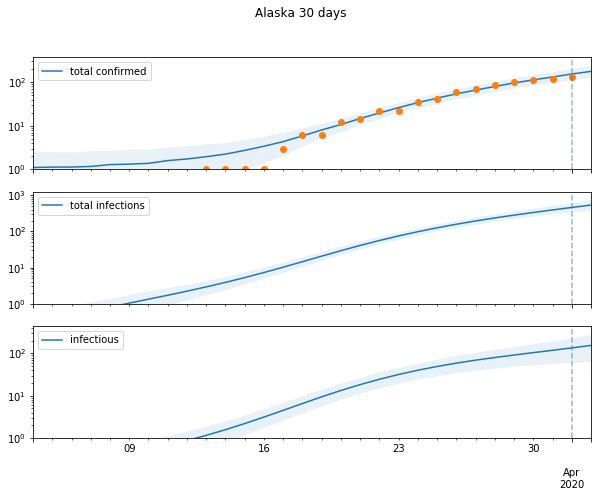

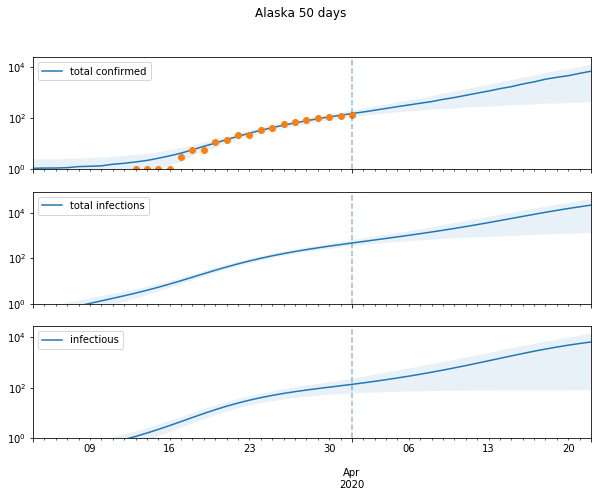

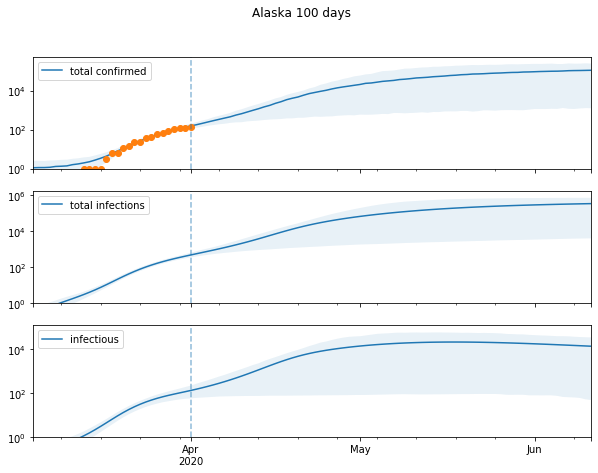

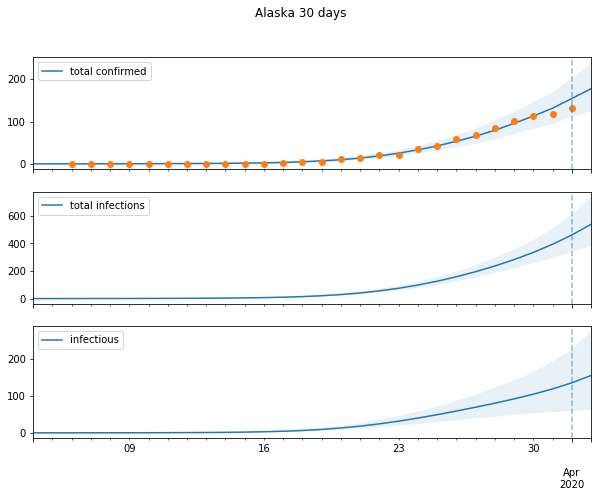

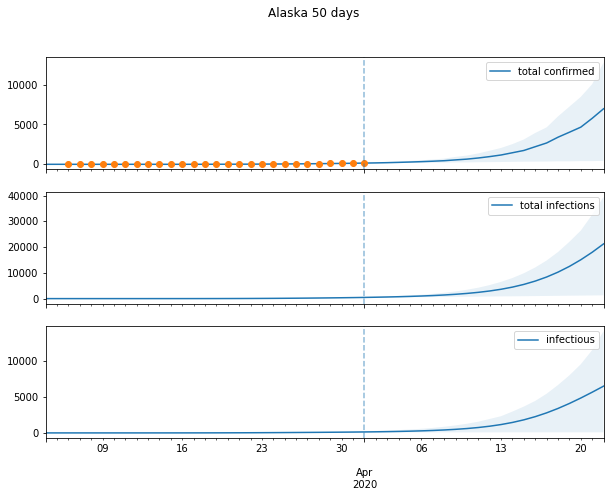

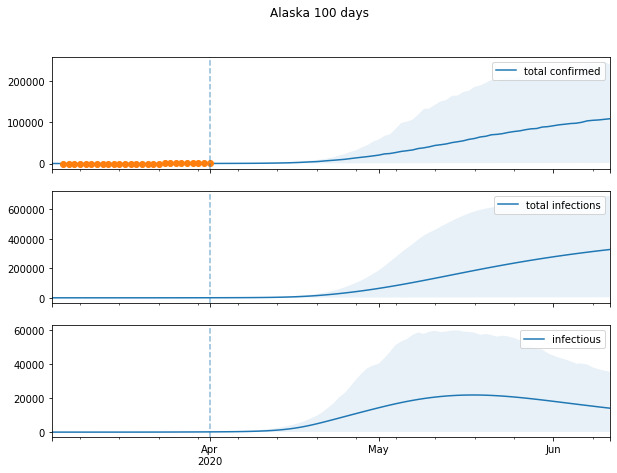

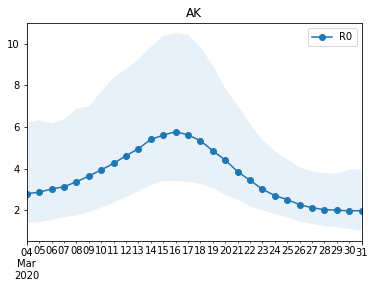

In [121]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
#places = ['NY']
#places = state_data.keys()
places = ['AK']
#places = ['US']

save = True

for place in places:
    
    print(place)
    confirmed = data[place]['data'].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = data[place]['pop']

    prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place)
    
    # Inspect and Save Results    
    for scale in ['log', 'lin']:
        for T in [30, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')
            
            fig, ax = plt.subplots(nrows=3, figsize=(10,7), sharex=True)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[0], plot_fields=['y'], model=model)
            confirmed.plot(ax=ax[0], style='o')

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[1], plot_fields=['C'], model=model)

            plot_samples(post_pred_samples, T=T, t=t, ax=ax[2], plot_fields=['I'], model=model)

            [a.axvline(confirmed.index.max(), linestyle='--', alpha=0.5) for a in ax]

            name = data[place]['name']
            plt.suptitle(f'{name} {T} days ')
            
            if scale == 'log':
                for a in ax:
                    a.set_yscale('log')
                    
                    # Don't display below 1
                    bottom, top = a.get_ylim()
                    bottom = 1 if bottom < 1 else bottom
                    a.set_ylim(bottom=bottom)
                
            if save:
                filename = f'vis/{place}_predictive_scale_{scale}_T_{T}.png'
                plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': np.median(R0, axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    if save:
        filename = f'vis/{place}_R0.png'
        plt.savefig(filename)

    plt.title(place)
    plt.show()

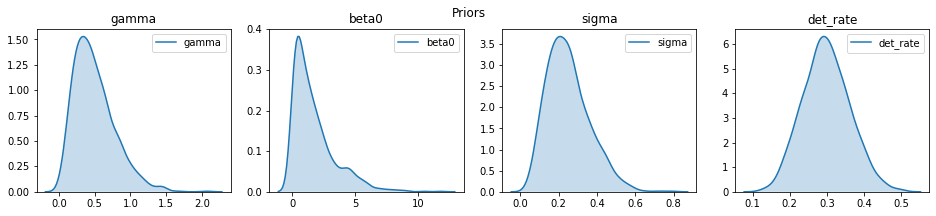

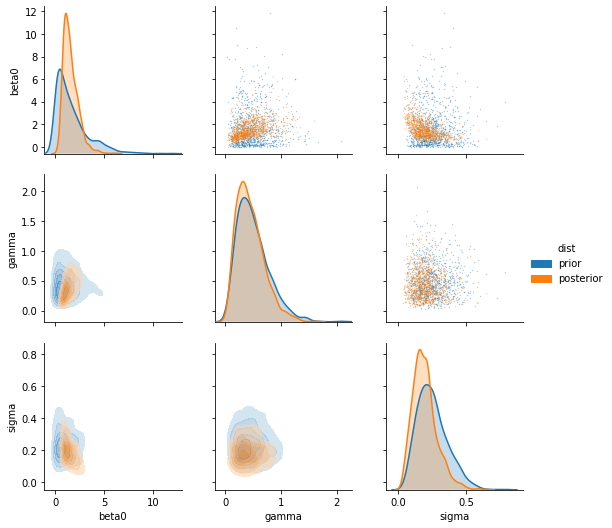

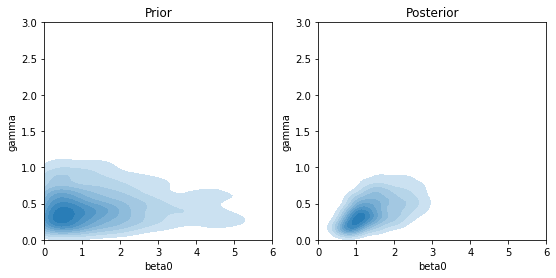

In [116]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

In [ ]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [ ]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

In [ ]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

obs None
mask True
latent 21.073795
conc 21.073795
obs None
mask True
latent [42.473885 57.430233 67.73228  74.847534 79.79063  83.27124  85.77236
 87.59995  88.95409 ]
conc [42.473885 57.430233 67.73228  74.847534 79.79063  83.27124  85.77236
 87.59995  88.95409 ]
obs None
mask True
latent [89.96954  90.7382   91.32153  91.76903  92.11687  92.38569  92.592354
 92.750084 92.87015  92.96158 ]
conc [89.96954  90.7382   91.32153  91.76903  92.11687  92.38569  92.592354
 92.750084 92.87015  92.96158 ]


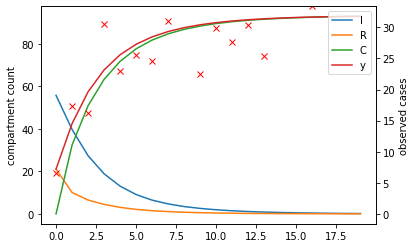

obs None
mask True
latent 25.137352
conc 25.137352
obs None
mask True
latent [  41.71712   74.23778  124.93823  200.63959  311.50626  475.10162
  719.67834 1059.3444  1486.3593 ]
conc [  41.71712   74.23778  124.93823  200.63959  311.50626  475.10162
  719.67834 1059.3444  1486.3593 ]
obs None
mask True
latent [2013.2125 2657.2175 3388.94   4157.9194 4916.5317 5628.0957 6279.02
 6856.129  7353.726  7775.588 ]
conc [2013.2125 2657.2175 3388.94   4157.9194 4916.5317 5628.0957 6279.02
 6856.129  7353.726  7775.588 ]


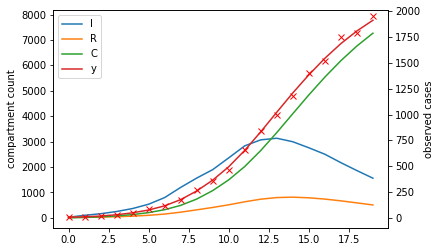

obs None
mask True
latent 86.72502
conc 86.72502
obs None
mask True
latent [ 143.26779  225.25366  334.66684  478.65442  670.57874  926.36237
 1257.7377  1674.1434  2198.0376 ]
conc [ 143.26779  225.25366  334.66684  478.65442  670.57874  926.36237
 1257.7377  1674.1434  2198.0376 ]
obs None
mask True
latent [2847.115  3596.16   4401.864  5204.997  5942.989  6600.056  7174.3726
 7660.427  8060.8813 8383.916 ]
conc [2847.115  3596.16   4401.864  5204.997  5942.989  6600.056  7174.3726
 7660.427  8060.8813 8383.916 ]


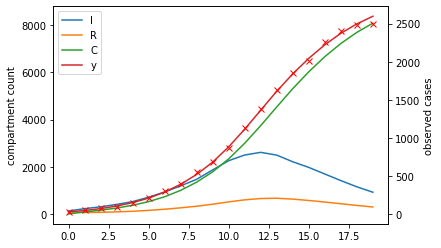

obs None
mask True
latent 95.30516
conc 95.30516
obs None
mask True
latent [118.16307 141.87367 164.65259 186.21371 206.52202 225.72505 243.86621
 260.9295  276.9862 ]
conc [118.16307 141.87367 164.65259 186.21371 206.52202 225.72505 243.86621
 260.9295  276.9862 ]
obs None
mask True
latent [292.07    306.18768 319.35104 331.60358 343.00858 353.58795 363.35422
 372.33722 380.5635  388.08658]
conc [292.07    306.18768 319.35104 331.60358 343.00858 353.58795 363.35422
 372.33722 380.5635  388.08658]


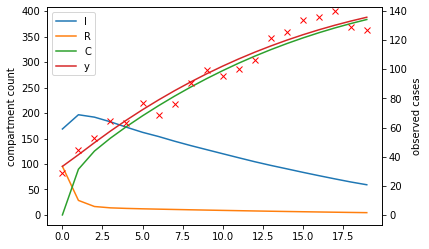

obs None
mask True
latent 156.89616
conc 156.89616
obs None
mask True
latent [ 212.75037  329.22562  499.93567  736.18396 1049.2792  1458.3102
 1983.4807  2609.097   3306.3704 ]
conc [ 212.75037  329.22562  499.93567  736.18396 1049.2792  1458.3102
 1983.4807  2609.097   3306.3704 ]
obs None
mask True
latent [4043.8745 4786.2783 5504.2544 6171.1562 6768.0063 7288.617  7734.706
 8111.116  8425.377  8685.679 ]
conc [4043.8745 4786.2783 5504.2544 6171.1562 6768.0063 7288.617  7734.706
 8111.116  8425.377  8685.679 ]


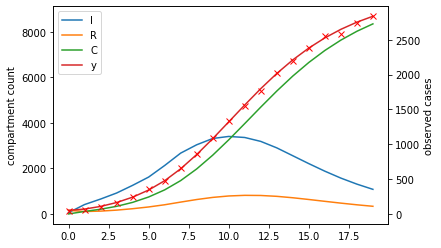

In [58]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x[:,1:])    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N, det_conc=200)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=10, T_future=10, N=1e4, det_conc=1)
        
#    samples = test_prior_predictive()

In [86]:
x = np.arange(10)

y = 5

print(np.minimum(x, y))

[0 1 2 3 4 5 5 5 5 5]
